# CI project :Natural-inspired pattern Recognition for Classification Proplem



### Hyperparameter Optimization (HPO) of Machine Learning Models
####  Tradional Algorithms versus Natural inspired Algorithms

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,classification_report,accuracy_score
from sklearn import datasets
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor


## Load MNIST dataset
The MNIST database  is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples.

In [10]:
dataset = datasets.load_digits()
X = dataset.data
y = dataset.target

In [11]:
dataset

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [23]:
#SVM
clf = SVC()
clf.fit(X,y)
scores = cross_val_score(clf, X ,y, cv=3 , scoring ='accuracy')
print("Accuracy:"+ str(scores.mean()))


Accuracy:0.9699499165275459


## Tradition Parameter tunning Methods  Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [28]:
# SVM optimized by GridSearchCv
from sklearn.model_selection import GridSearchCV
#Define hyperparameter Configuration space
svm_params = {
    'C':[1, 10, 100],
    'kernel' :['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid =GridSearchCV(clf,svm_params ,cv=3 ,scoring = 'accuracy')
grid.fit(X,y)
print(grid.best_params_)
print("Accuracy:"+str(grid.best_score_))
svc_accuracy_bygridsearch = grid.best_score_
svc_params_bygridsearch = grid.best_params_

{'C': 10, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


##  Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [29]:
#SVM
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
n_iter_search=20
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))
svc_accuracy_byrandomsearch = Random.best_score_
svc_params_byrandomsearch = Random.best_params_

{'C': 18.117919163156486, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


## Define Binary BFO helpers
Define helper functions for Binary Bacterial Foraging Optimization (BBFO), including binary chromosome decoding, population initialization, fitness evaluation, and bit-flipping (mutation).


In [30]:
def decode_chromosome(chromosome):
    # First 10 bits for C
    c_bits = chromosome[:10]
    c_value = int("".join(map(str, c_bits)), 2)
    c_real = 0.1 + (1000 - 0.1) * (c_value / (2**10 - 1))

    # Last 2 bits for kernel
    kernel_bits = chromosome[10:]
    kernel_idx = int("".join(map(str, kernel_bits)), 2)
    kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']
    kernel_value = kernel_options[kernel_idx % 4]  # to avoid index error

    return {'C': c_real, 'kernel': kernel_value}


## Run Binary BFO optimization
Execute the BBFO algorithm to optimize SVM hyperparameters (C and kernel). Track best accuracy over generations.


In [31]:
import random

def initialize_population(pop_size, n_bits):
    return [np.random.randint(0, 2, n_bits).tolist() for _ in range(pop_size)]

def evaluate(chromosome, X, y):
    params = decode_chromosome(chromosome)
    clf = SVC(C=params['C'], kernel=params['kernel'], gamma='scale')
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    return scores.mean()

def flip_bit(chromosome, prob=0.1):
    return [(1 - bit if random.random() < prob else bit) for bit in chromosome]

def binary_bfo(X, y, n_gen=20, pop_size=10):
    n_bits = 12
    population = initialize_population(pop_size, n_bits)
    fitness_over_gens = []

    best_solution = None
    best_fitness = 0

    for gen in range(n_gen):
        new_population = []
        fitnesses = []

        for bacterium in population:
            mutated = flip_bit(bacterium, prob=0.1)
            mutated_fitness = evaluate(mutated, X, y)
            original_fitness = evaluate(bacterium, X, y)

            if mutated_fitness > original_fitness:
                new_population.append(mutated)
                fitnesses.append(mutated_fitness)
            else:
                new_population.append(bacterium)
                fitnesses.append(original_fitness)

        population = new_population
        gen_best = max(fitnesses)
        if gen_best > best_fitness:
            best_fitness = gen_best
            best_solution = population[fitnesses.index(gen_best)]

        fitness_over_gens.append(gen_best)
        print(f"Generation {gen+1} - Best Accuracy: {gen_best:.4f}")

    return best_solution, best_fitness, fitness_over_gens


## Decode best BBFO result 
Extract the best SVM parameters from the BBFO result and print the best accuracy.


In [34]:
best_solution, svc_accuracy_bybbfo, fitness_curve = binary_bfo(X, y)
svc_params_bybbfo = decode_chromosome(best_solution)

print("Best Params (BBFO):", svc_params_bybbfo)
print("Best Accuracy (BBFO):", svc_accuracy_bybbfo)

Generation 1 - Best Accuracy: 0.9738
Generation 2 - Best Accuracy: 0.9738
Generation 3 - Best Accuracy: 0.9738
Generation 4 - Best Accuracy: 0.9738
Generation 5 - Best Accuracy: 0.9738
Generation 6 - Best Accuracy: 0.9738
Generation 7 - Best Accuracy: 0.9738
Generation 8 - Best Accuracy: 0.9738
Generation 9 - Best Accuracy: 0.9738
Generation 10 - Best Accuracy: 0.9738
Generation 11 - Best Accuracy: 0.9738
Generation 12 - Best Accuracy: 0.9738
Generation 13 - Best Accuracy: 0.9738
Generation 14 - Best Accuracy: 0.9738
Generation 15 - Best Accuracy: 0.9738
Generation 16 - Best Accuracy: 0.9738
Generation 17 - Best Accuracy: 0.9738
Generation 18 - Best Accuracy: 0.9738
Generation 19 - Best Accuracy: 0.9738
Generation 20 - Best Accuracy: 0.9738
Best Params (BBFO): {'C': 525.9516129032259, 'kernel': 'rbf'}
Best Accuracy (BBFO): 0.9738452977184195


## Accuracy comparison plot
Compare the accuracies of GridSearchCV, RandomizedSearchCV, and Binary BFO using a bar chart.


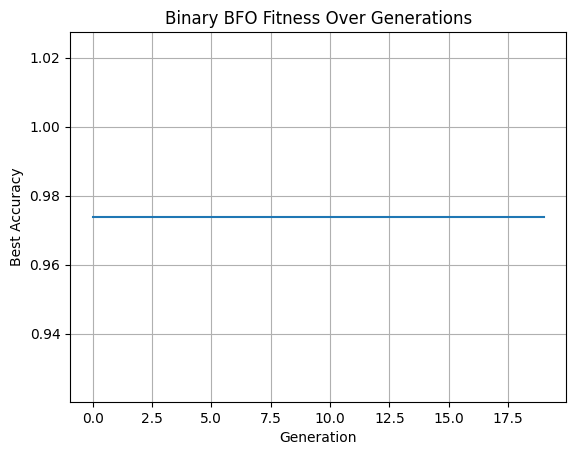

In [35]:
plt.plot(fitness_curve)
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.title("Binary BFO Fitness Over Generations")
plt.grid()
plt.show()


## Print best parameters and accuracies
 Display a side-by-side comparison of the best parameters and accuracies obtained from each optimization method.


=== Accuracy Comparison ===
GridSearchCV Accuracy:     0.9738 | Params: {'C': 10, 'kernel': 'rbf'}
RandomSearchCV Accuracy:   0.9738 | Params: {'C': 18.117919163156486, 'kernel': 'rbf'}
Binary BFO Accuracy:       0.9738 | Params: {'C': 525.9516129032259, 'kernel': 'rbf'}


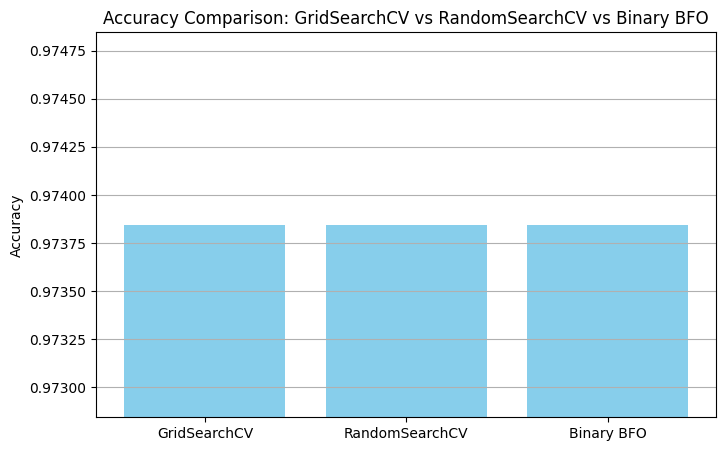

In [36]:
print("=== Accuracy Comparison ===")
print(f"GridSearchCV Accuracy:     {svc_accuracy_bygridsearch:.4f} | Params: {svc_params_bygridsearch}")
print(f"RandomSearchCV Accuracy:   {svc_accuracy_byrandomsearch:.4f} | Params: {svc_params_byrandomsearch}")
print(f"Binary BFO Accuracy:       {svc_accuracy_bybbfo:.4f} | Params: {svc_params_bybbfo}")


import matplotlib.pyplot as plt

results = {
    'GridSearchCV': svc_accuracy_bygridsearch,
    'RandomSearchCV': svc_accuracy_byrandomsearch,
    'Binary BFO': svc_accuracy_bybbfo
}

labels = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.001, max(accuracies) + 0.001)
plt.title('Accuracy Comparison: GridSearchCV vs RandomSearchCV vs Binary BFO')
plt.grid(axis='y')
plt.show()
